In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import numpy as np

import matplotlib.pyplot as plt

from time import time
from IPython.display import clear_output

In [4]:
mnist_dataset = torchvision.datasets.MNIST(root='./data/', download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5), (0.5))
                             ]))
print(len(mnist_dataset))

60000


In [5]:
BATCH_SIZE = 256
TRAIN_RATIO = 0.5

In [6]:
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [int(TRAIN_RATIO * len(mnist_dataset)), len(mnist_dataset) - int(TRAIN_RATIO * len(mnist_dataset))])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class ModelTrainer:
    def __init__(self, train_generator, test_generator):
        self.__model = None
        self.__train_generator = train_generator
        self.__test_generator = test_generator

    def set_model(self, model, model_name='model'):
        self.__model = model
        self.__model_name = model_name

    def get_model(self):
        return self.__model

    def get_model_name(self):
        return self.__model_name
    
    def train_epoch(self, optimizer, batch_size=32, cuda=True):
        assert self.__model is not None
        
        model = self.__model

        loss_log, acc_log = [], []
        model.train()
        steps = 0
        for batch_num, (x_batch, y_batch) in enumerate(self.__train_generator):
            data = x_batch.cuda() if cuda else x_batch
            target = y_batch.cuda() if cuda else y_batch

            optimizer.zero_grad()
            output = model(data)
            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = F.nll_loss(output, target).cpu()
            loss.backward()
            optimizer.step()
            loss = loss.item()
            loss_log.append(loss)
            
            steps += 1
            print('Step {0}'.format(steps), flush=True, end='\r')

        return loss_log, acc_log, steps
        

    def train(self, n_epochs, batch_size=32, lr=1e-3, cuda=True, plot_history=None, clear_output=None):
        assert self.__model is not None
    
        if cuda:
            self.__model = self.__model.cuda()
        else:
            self.__model = self.__model.cpu()

        model = self.__model
        opt = torch.optim.AdamW(model.parameters(), lr=lr)

        train_log, train_acc_log = [], []
        val_log, val_acc_log = [], []

        best_val_score = 0.

        for epoch in range(n_epochs):
            epoch_begin = time()
            print("Epoch {0} of {1}".format(epoch, n_epochs))
            train_loss, train_acc, steps = self.train_epoch(opt, batch_size=batch_size, cuda=cuda)

            val_loss, val_acc = self.test(cuda=cuda)

            train_log.extend(train_loss)
            train_acc_log.extend(train_acc)

            val_log.append((steps * (epoch + 1), np.mean(val_loss)))
            val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

            if np.mean(val_acc) > best_val_score:
                best_val_score = np.mean(val_acc)
                torch.save(model, self.__model_name + '_best.pth')
            
            if plot_history is not None:
                clear_output()
                plot_history(train_log, val_log)
                plot_history(train_acc_log, val_acc_log, title='accuracy')   
            epoch_end = time()
            epoch_time = epoch_end - epoch_begin
            print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))
            print("Epoch: {2}, train loss: {0}, train accuracy: {1}".format(np.mean(train_loss), np.mean(train_acc), epoch))
            print('Epoch time: {0}'.format(epoch_time))
        self.__model = model.cpu()

    def test(self, cuda=True):
        assert self.__model is not None
        
        model = self.__model.cuda() if cuda else self.__model
        
        loss_log, acc_log = [], []
        model.eval()
        
        for batch_num, (x_batch, y_batch) in enumerate(self.__test_generator):    
            data = x_batch.cuda() if cuda else x_batch
            target = y_batch.cuda() if cuda else y_batch

            output = model(data)
            loss = F.nll_loss(output, target).cpu()

            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = loss.item()
            loss_log.append(loss)

        return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [113]:
trainer = ModelTrainer(train_loader, val_loader)

In [114]:
base_channel = 8
model = nn.Sequential(# 28 * 28
    nn.Conv2d(1, base_channel, kernel_size=3, stride=1, dilation=1),  # 26*26
    nn.ReLU(),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, dilation=1),  # 24 * 24
    nn.ReLU(),
    nn.Conv2d(base_channel, 2 * base_channel, kernel_size=3, stride=2, dilation=1, padding=1),  # 12 * 12
    nn.ReLU(),
    nn.Conv2d(2 * base_channel, 2 * base_channel, kernel_size=3, stride=1, dilation=1),  # 10*10
    nn.ReLU(),
    nn.Conv2d(2 * base_channel, 4 * base_channel, kernel_size=3, stride=1, dilation=1),  # 8 * 8
    nn.ReLU(),
    nn.Conv2d(4 * base_channel, 4 * base_channel, kernel_size=3, stride=1, dilation=1),  # 6 * 6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6 * 6 * 4 * base_channel, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

In [115]:
trainer.set_model(model)

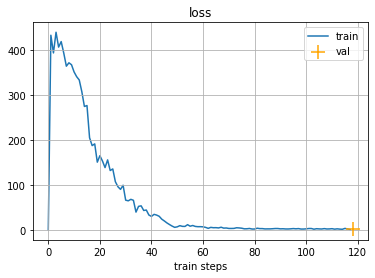

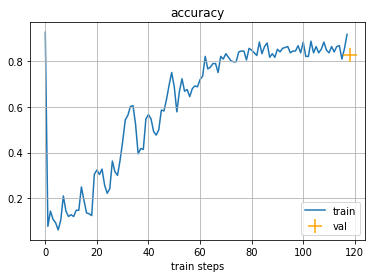

Epoch: 0, val loss: 2.875169558040166, val accuracy: 0.8245497941970825
Epoch: 0, train loss: 72.08911228937617, train accuracy: 0.6152895092964172
Epoch time: 7.093629837036133


In [131]:
trainer.train(n_epochs=1, batch_size=BATCH_SIZE, lr=1e-3, cuda=True, plot_history=plot_history, clear_output=clear_output)

In [117]:
trainer.get_model()[-4].weight.data.requires_grad

False

In [118]:
loss, acc = map(np.mean, trainer.test(cuda=True))

In [119]:
loss, acc

(0.2940014191603256, 0.910697)

In [120]:
model = model.cpu()

Change outputs amount 

In [121]:
INJECTED_SIZE = 10

In [122]:
def fake_output_ones(layer, ones_num):
    prev_weights = layer.weight.data.detach().clone()
    prev_bias = layer.bias.data.detach().clone()
    new_layer = nn.Linear(layer.in_features, layer.out_features + ones_num)
    new_layer.weight.data = torch.cat([prev_weights, torch.zeros(ones_num, new_layer.in_features)])
    new_layer.bias.data = torch.cat([prev_bias, torch.ones(ones_num)])
    return new_layer

In [123]:
model[-4] = fake_output_ones(model[-4], INJECTED_SIZE)

In [124]:
def inject_fake_matrix(layer, fake_tensor):
    prev_weights = layer.weight.data.detach().clone()
    prev_bias = layer.bias.data.detach().clone()
    new_layer = nn.Linear(layer.in_features + fake_tensor.shape[1], layer.out_features)
    print(new_layer.weight.data.shape)
    new_layer.weight.data = torch.cat([prev_weights, fake_tensor], dim=-1)
    new_layer.bias.data = prev_bias - fake_tensor.sum(dim=-1)
    return new_layer

In [133]:
fake_tensor = torch.arange(10*INJECTED_SIZE).view(10, -1)

In [125]:
model[-2] = inject_fake_matrix(model[-2], fake_tensor)

torch.Size([10, 74])


In [126]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1152, out_features=74, bias=True)
  (14): ReLU()
  (15): Linear(in_features=74, out_features=10, bias=True)
  (16): LogSoftmax(dim=1)
)

In [127]:
loss, acc = map(np.mean, trainer.test(cuda=True))

In [128]:
loss, acc

(0.29400167399543825, 0.910697)

In [136]:
(trainer.get_model()[-2].weight.data[:, -INJECTED_SIZE:] - fake_tensor).mean()

tensor(-0.0596)